In [49]:
# Cell 1: Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import rasterio
from rasterio.plot import show
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import cv2
import random

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Display TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.17.1


Number of multispectral images: 306
Number of label masks: 456
Number of matching image-label pairs: 306
Image shape: (12, 128, 128)
Number of channels: 12
Channel data types: ('int16', 'int16', 'int16', 'int16', 'int16', 'int16', 'int16', 'int16', 'int16', 'int16', 'int16', 'int16')
Resolution: (1.0, 1.0)
Coordinate reference system: None


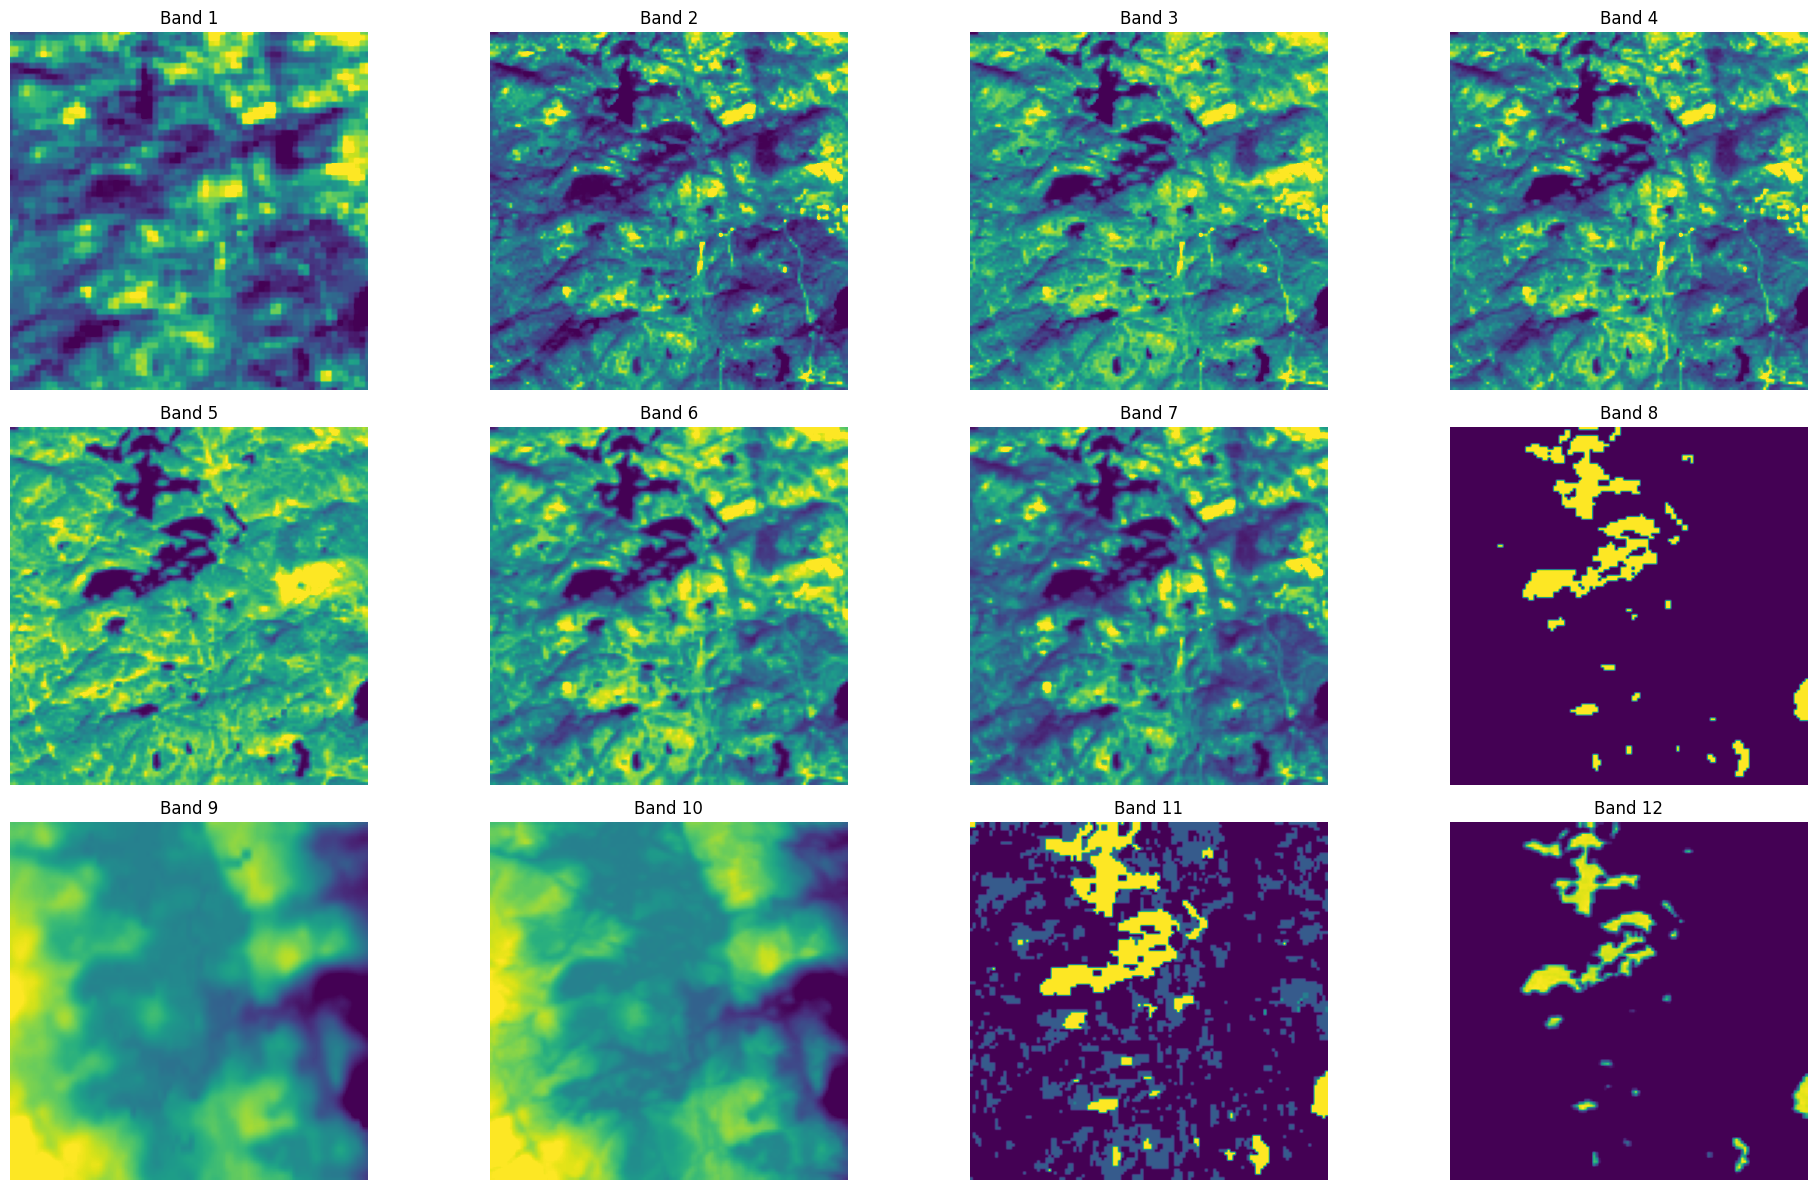

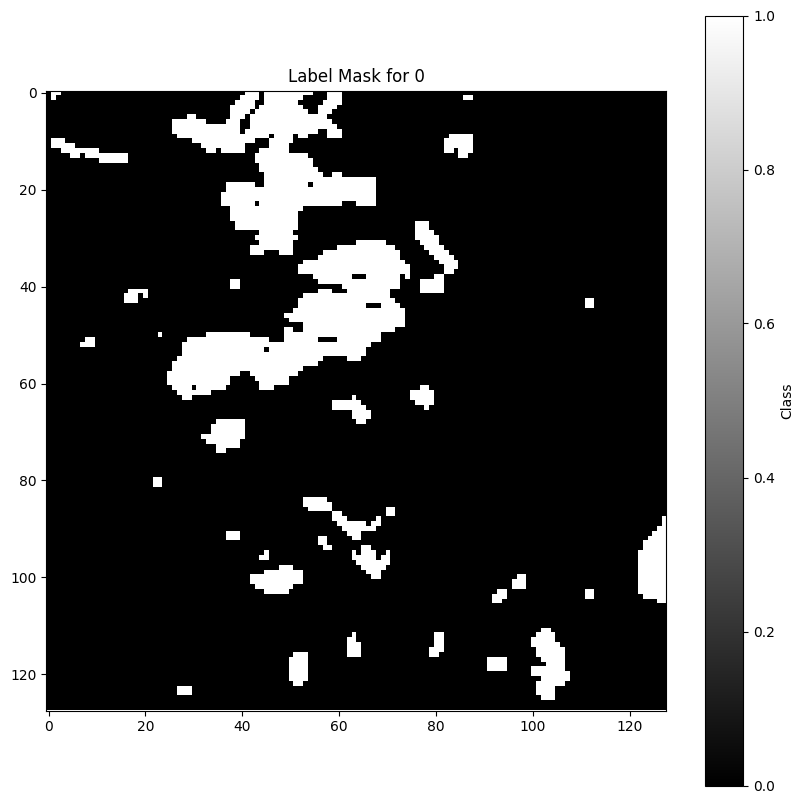


Label statistics:
  Class 0: 14467 pixels (88.30%)
  Class 1: 1917 pixels (11.70%)


In [51]:
# Cell 2: Define paths and examine data structure
# Update these paths to match your Kaggle setup
DATA_DIR = '/kaggle/input/waterdataset/data'
IMAGE_DIR = os.path.join(DATA_DIR, 'images')
LABEL_DIR = os.path.join(DATA_DIR, 'labels')

# List files and check counts
image_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith('.tif')])
label_files = sorted([f for f in os.listdir(LABEL_DIR) if f.endswith('.png')])

print(f"Number of multispectral images: {len(image_files)}")
print(f"Number of label masks: {len(label_files)}")

# Find common files (ensuring image-label pairs match)
image_names = set([os.path.splitext(f)[0] for f in image_files])
label_names = set([os.path.splitext(f)[0] for f in label_files])
common_names = sorted(list(image_names.intersection(label_names)))

print(f"Number of matching image-label pairs: {len(common_names)}")

# Cell 3: Explore a sample image to understand data structure
def explore_sample_image(idx=0):
    """Explore a sample multispectral image and its corresponding label"""
    img_name = common_names[idx]
    img_path = os.path.join(IMAGE_DIR, f"{img_name}.tif")
    label_path = os.path.join(LABEL_DIR, f"{img_name}.png")
    
    # Read multispectral image with rasterio
    with rasterio.open(img_path) as src:
        img_data = src.read()
        print(f"Image shape: {img_data.shape}")
        print(f"Number of channels: {src.count}")
        print(f"Channel data types: {src.dtypes}")
        print(f"Resolution: {src.res}")
        print(f"Coordinate reference system: {src.crs}")
        
        # Plot a few sample bands
        fig, axes = plt.subplots(3, 4, figsize=(20, 12))
        axes = axes.flatten()
        
        for i in range(min(12, src.count)):
            ax = axes[i]
            band_data = img_data[i]
            vmin, vmax = np.percentile(band_data[band_data > 0], (2, 98))
            ax.imshow(band_data, cmap='viridis', vmin=vmin, vmax=vmax)
            ax.set_title(f"Band {i+1}")
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Read and display label
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    plt.figure(figsize=(10, 10))
    plt.imshow(label, cmap='gray')
    plt.title(f"Label Mask for {img_name}")
    plt.colorbar(label="Class")
    plt.show()
    
    # Check label statistics
    unique_vals, counts = np.unique(label, return_counts=True)
    print("\nLabel statistics:")
    for val, count in zip(unique_vals, counts):
        print(f"  Class {val}: {count} pixels ({count/label.size*100:.2f}%)")
    
    return img_data, label

# Execute the exploration function
sample_img, sample_label = explore_sample_image(0)

Training samples: 244
Validation samples: 31
Test samples: 31


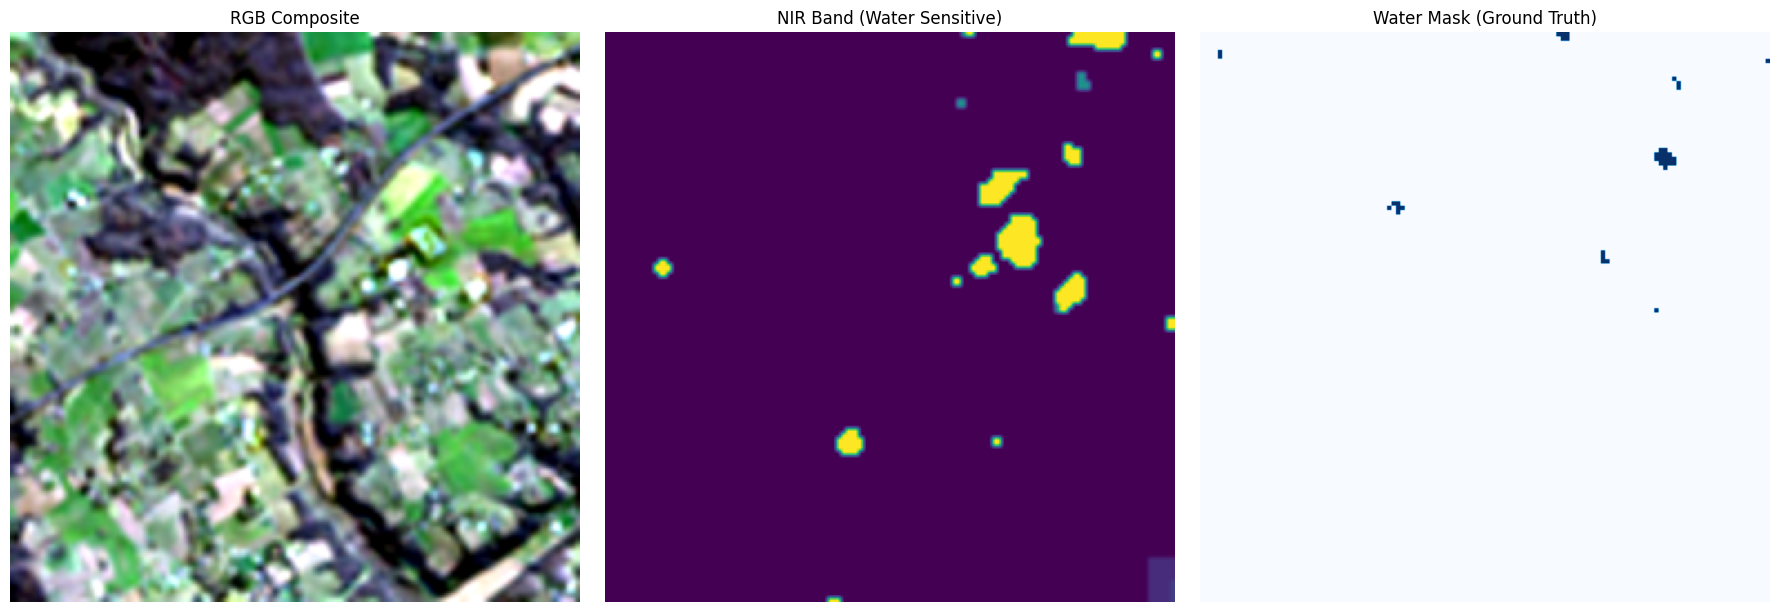

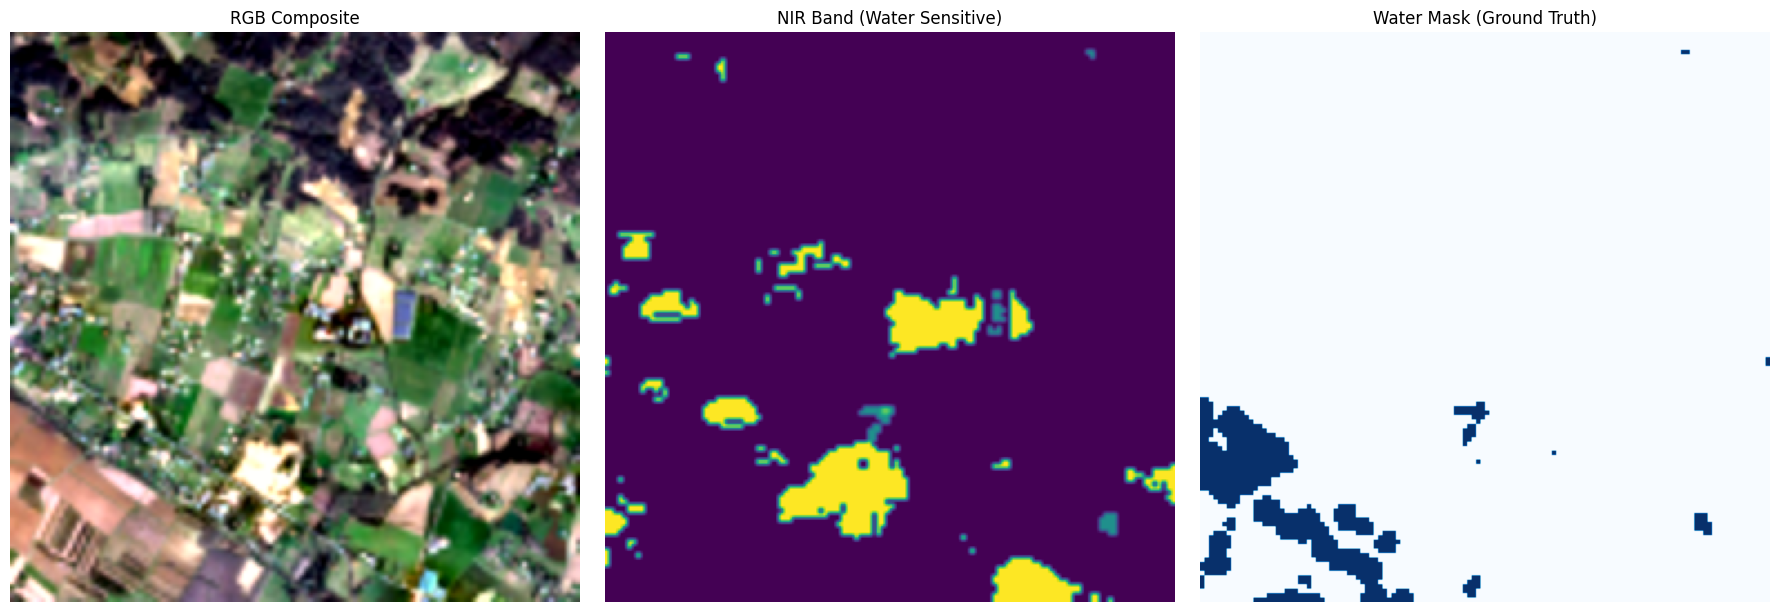

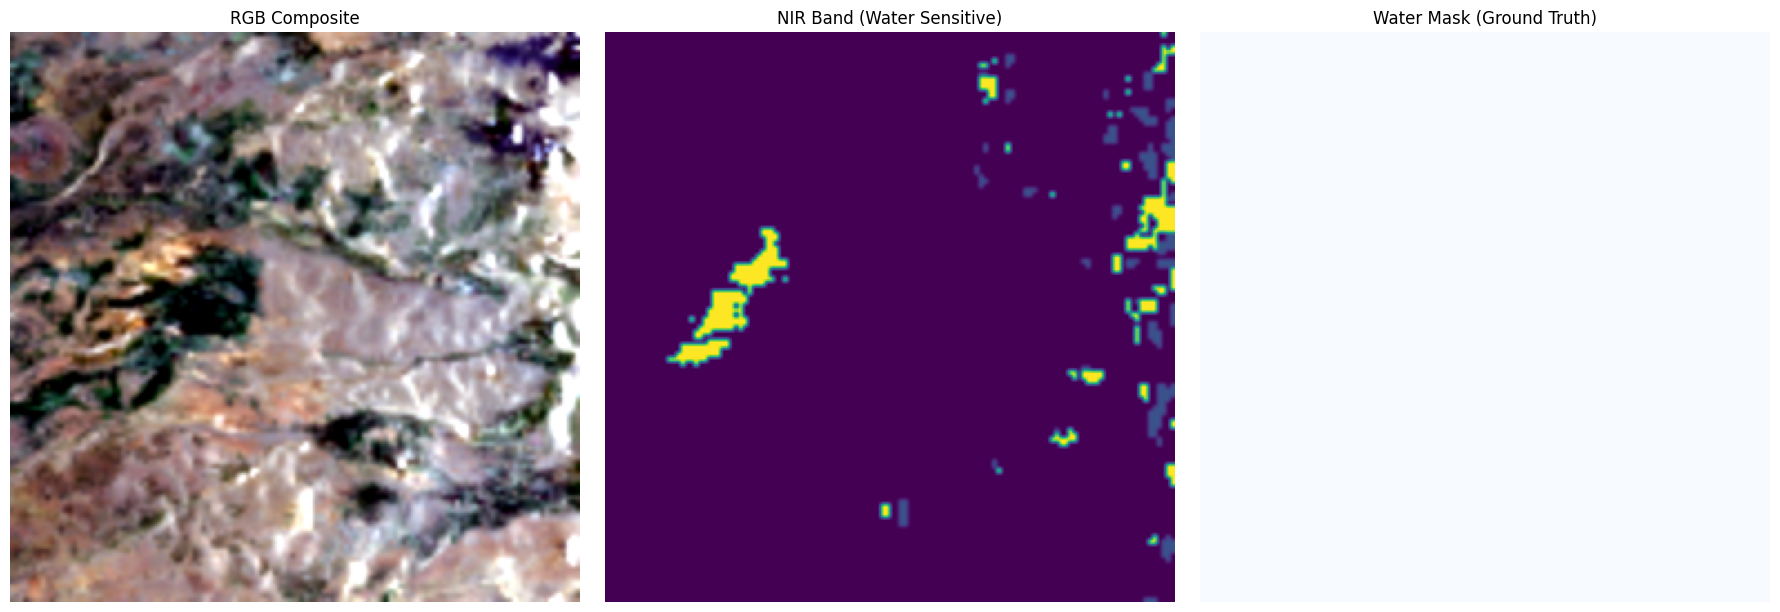

In [52]:
# Cell 4: Data preprocessing functions
def normalize_band(band, percentiles=(2, 98)):
    """Normalize a band using percentile clipping to handle outliers"""
    band = band.astype(np.float32)
    # Get valid data (non-zero/non-nan)
    valid_data = band[np.isfinite(band) & (band != 0)]
    if len(valid_data) == 0:
        return np.zeros_like(band, dtype=np.float32)
    
    # Calculate percentiles from valid data
    min_val, max_val = np.percentile(valid_data, percentiles)
    # Clip and normalize
    band = np.clip(band, min_val, max_val)
    band = (band - min_val) / (max_val - min_val + 1e-10)
    # Replace any remaining nan/inf values
    band = np.nan_to_num(band, nan=0, posinf=1, neginf=0)
    return band

def load_and_preprocess_image(img_path, normalize=True):
    """Load and preprocess a multispectral image"""
    with rasterio.open(img_path) as src:
        img_data = src.read()
    
    if normalize:
        # Normalize each band individually
        normalized_img = np.zeros_like(img_data, dtype=np.float32)
        for i in range(img_data.shape[0]):
            normalized_img[i] = normalize_band(img_data[i])
        return normalized_img
    return img_data

def load_mask(mask_path, binary=True):
    """Load and preprocess a mask image"""
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if binary:
        # Convert to binary water/non-water mask (assumes water is class 1)
        # Adjust this if your labeling convention is different
        mask = (mask == 1).astype(np.float32)
    return mask

# Cell 5: Data augmentation functions
def augment_data(image, mask):
    """Apply random augmentations to image-mask pairs"""
    # Determine image shape
    channels, height, width = image.shape
    
    # Random horizontal flip
    if random.random() > 0.5:
        image = np.flip(image, axis=2)
        mask = np.flip(mask, axis=1)
    
    # Random vertical flip
    if random.random() > 0.5:
        image = np.flip(image, axis=1)
        mask = np.flip(mask, axis=0)
    
    # Random 90-degree rotations
    k = random.randint(0, 3)
    if k > 0:
        image = np.rot90(image, k=k, axes=(1, 2))
        mask = np.rot90(mask, k=k, axes=(0, 1))
        
    # Random brightness adjustment (adjust all bands slightly differently)
    if random.random() > 0.5:
        for i in range(channels):
            factor = random.uniform(0.8, 1.2)
            image[i] = np.clip(image[i] * factor, 0, 1)
    
    return image, mask

# Cell 6: Create train/validation/test splits
def create_dataset_splits(common_names, test_size=0.1, val_size=0.1, random_state=42):
    """Split dataset into train, validation and test sets"""
    # First split: separate test set
    train_val_names, test_names = train_test_split(
        common_names, test_size=test_size, random_state=random_state
    )
    
    # Second split: separate validation set from training set
    adjusted_val_size = val_size / (1 - test_size)
    train_names, val_names = train_test_split(
        train_val_names, test_size=adjusted_val_size, random_state=random_state
    )
    
    print(f"Training samples: {len(train_names)}")
    print(f"Validation samples: {len(val_names)}")
    print(f"Test samples: {len(test_names)}")
    
    return train_names, val_names, test_names

# Cell 7: Data generator for training
class MultispectralDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_dir, label_dir, file_names, batch_size=8, 
                 img_size=(256, 256), augment=False, shuffle=True):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.file_names = file_names
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.file_names))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        return int(np.ceil(len(self.file_names) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_names = [self.file_names[i] for i in batch_indexes]
        
        X = []
        y = []
        
        for name in batch_names:
            # Load and preprocess image
            img_path = os.path.join(self.image_dir, f"{name}.tif")
            mask_path = os.path.join(self.label_dir, f"{name}.png")
            
            # Load data
            image = load_and_preprocess_image(img_path)
            mask = load_mask(mask_path)
            
            # Resize if needed
            if self.img_size:
                resized_image = np.zeros((image.shape[0], *self.img_size), dtype=np.float32)
                for i in range(image.shape[0]):
                    resized_image[i] = cv2.resize(image[i], self.img_size)
                image = resized_image
                mask = cv2.resize(mask, self.img_size, interpolation=cv2.INTER_NEAREST)
            
            # Apply augmentation if enabled
            if self.augment:
                image, mask = augment_data(image, mask)
            
            # Reshape mask to add channel dimension
            mask = np.expand_dims(mask, axis=-1)
            
            # Transpose image from (channels, height, width) to (height, width, channels)
            image = np.transpose(image, (1, 2, 0))
            
            X.append(image)
            y.append(mask)
        
        return np.array(X), np.array(y)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Cell 8: Create dataset splits
train_names, val_names, test_names = create_dataset_splits(common_names)

# Cell 9: Initialize data generators
IMG_SIZE = (256, 256)  # You can adjust this based on your GPU memory
BATCH_SIZE = 8

train_gen = MultispectralDataGenerator(
    IMAGE_DIR, LABEL_DIR, train_names, 
    batch_size=BATCH_SIZE, img_size=IMG_SIZE, augment=True
)

val_gen = MultispectralDataGenerator(
    IMAGE_DIR, LABEL_DIR, val_names,
    batch_size=BATCH_SIZE, img_size=IMG_SIZE, augment=False
)

test_gen = MultispectralDataGenerator(
    IMAGE_DIR, LABEL_DIR, test_names,
    batch_size=BATCH_SIZE, img_size=IMG_SIZE, augment=False
)

# Cell 10: Visualize some samples from the data generator
def visualize_generator_samples(generator, num_samples=3):
    """Visualize samples from the data generator"""
    X_batch, y_batch = generator[0]
    
    for i in range(min(num_samples, len(X_batch))):
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Visualize RGB composite (adjust bands if needed)
        rgb_composite = np.stack([
            X_batch[i,:,:,3],  # Red band (adjust based on your satellite data)
            X_batch[i,:,:,2],  # Green band
            X_batch[i,:,:,1]   # Blue band
        ], axis=-1)
        
        # Normalize for display
        rgb_min = np.percentile(rgb_composite, 2)
        rgb_max = np.percentile(rgb_composite, 98)
        rgb_display = np.clip((rgb_composite - rgb_min) / (rgb_max - rgb_min), 0, 1)
        
        # Water band visualization (NIR band is often good for water detection)
        water_band = X_batch[i,:,:,7]  # Adjust based on your satellite data (maybe NIR)
        
        # Display
        axes[0].imshow(rgb_display)
        axes[0].set_title("RGB Composite")
        axes[0].axis('off')
        
        axes[1].imshow(water_band, cmap='viridis')
        axes[1].set_title("NIR Band (Water Sensitive)")
        axes[1].axis('off')
        
        axes[2].imshow(y_batch[i,:,:,0], cmap='Blues')
        axes[2].set_title("Water Mask (Ground Truth)")
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()

# Visualize some training samples
visualize_generator_samples(train_gen)

Input shape: (256, 256, 12)


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 256, 256, 12)   │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 256, 256, 64)   │          6,976 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ conv2d_94[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_18          │ (None, 128, 128, 64)   │              0 │ conv2d_95[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_18[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ conv2d_96[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_19          │ (None, 64, 64, 128)    │              0 │ conv2d_97[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)        │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_19[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_99 (Conv2D)        │ (None, 64, 64, 256)    │        590,080 │ conv2d_98[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_20          │ (None, 32, 32, 256)    │              0 │ conv2d_99[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_100 (Conv2D)       │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_20[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_101 (Conv2D)       │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_100[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32, 32, 512)    │              0 │ conv2d_101[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_21          │ (None, 16, 16, 512)    │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_102 (Conv2D)       │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_21[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_103 (Conv2D)       │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_102[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 16, 16, 1024)   │              0 │ conv2d_103[0][0]       │
├──────────────────────

 Total params: 31,036,929 (118.40 MB)

 Trainable params: 31,036,929 (118.40 MB)

 Non-trainable params: 0 (0.00 B)

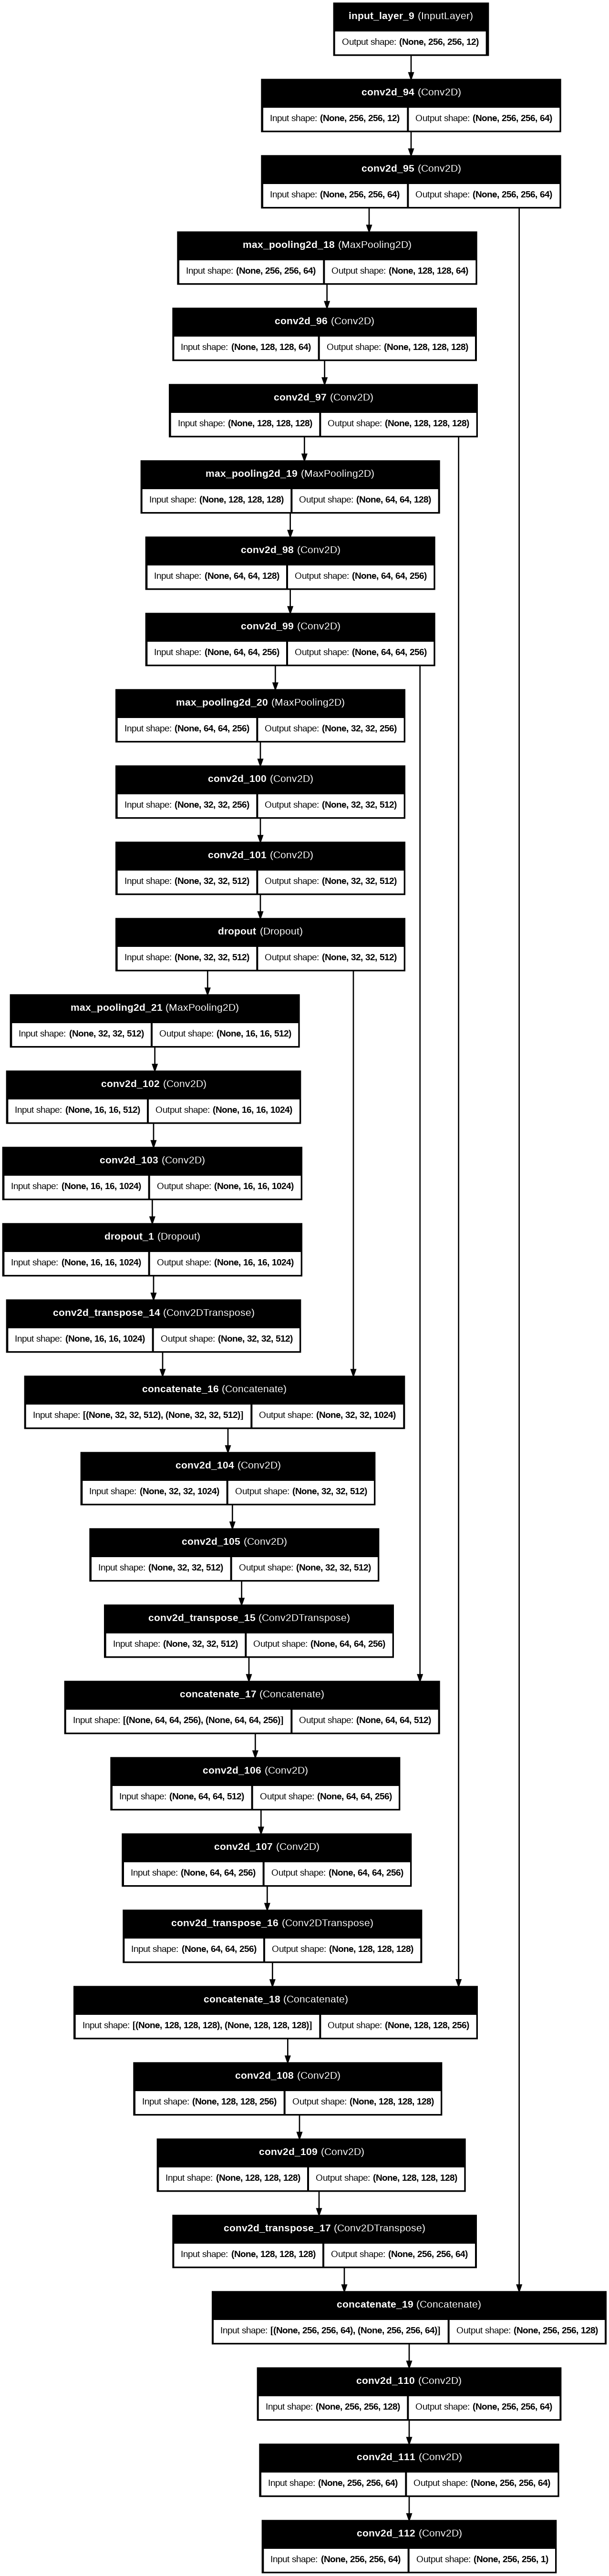

In [53]:
# Cell 11: Define U-Net model architecture
def build_unet_model(input_shape, num_classes=1):
    """Build a U-Net model for multispectral water segmentation"""
    inputs = layers.Input(shape=input_shape)
    
    # Encoder (downsampling path)
    # Block 1
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # Block 2
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Block 3
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Block 4
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)
    
    # Bridge
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = layers.Dropout(0.5)(conv5)
    
    # Decoder (upsampling path)
    # Block 6
    up6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(drop5)
    merge6 = layers.concatenate([drop4, up6], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
    # Block 7
    up7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
    # Block 8
    up8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
    # Block 9
    up9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
    # Output layer
    if num_classes == 1:
        outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)
    else:
        outputs = layers.Conv2D(num_classes, 1, activation='softmax')(conv9)
    
    model = models.Model(inputs, outputs)
    return model

# Cell 12: Define loss functions and metrics
def dice_coefficient(y_true, y_pred, smooth=1):
    """Calculate Dice coefficient"""
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    """Calculate Dice loss"""
    return 1 - dice_coefficient(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    """Combine binary cross entropy and Dice loss"""
    bce = tf.keras.losses.BinaryCrossentropy()
    return bce(y_true, y_pred) + dice_loss(y_true, y_pred)

# Calculate IoU (Intersection over Union)
def iou_score(y_true, y_pred, smooth=1):
    """Calculate IoU (Jaccard index)"""
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(tf.cast(y_pred > 0.5, tf.float32))
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# Cell 13: Create and compile the model
# Get sample from generator to determine input shape
X_sample, _ = train_gen[0]
input_shape = X_sample.shape[1:]
print(f"Input shape: {input_shape}")

# Build model
model = build_unet_model(input_shape)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=bce_dice_loss,
    metrics=[dice_coefficient, iou_score, 'accuracy']
)

# Print model summary
model.summary()

# Cell 14: Visualize the model architecture
tf.keras.utils.plot_model(
    model, 
    to_file='unet_model.png', 
    show_shapes=True,
    show_layer_names=True,
    dpi=96
)


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7243 - dice_coefficient: 0.3168 - iou_score: 0.2479 - loss: 1.3124
Epoch 1: val_iou_score improved from -inf to 0.61501, saving model to water_segmentation_model_best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.7264 - dice_coefficient: 0.3180 - iou_score: 0.2495 - loss: 1.3089 - val_accuracy: 0.8503 - val_dice_coefficient: 0.5389 - val_iou_score: 0.6150 - val_loss: 0.9032 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.8663 - dice_coefficient: 0.5109 - iou_score: 0.5008 - loss: 0.8728
Epoch 2: val_iou_score improved from 0.61501 to 0.64242, saving model to water_segmentation_model_best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 709ms/step - accuracy: 0.8664 - dice_coefficient: 0.5131 - iou_score: 0.5017 - loss: 0.8701 - val_accuracy: 0.8746 - val_dice_coefficient: 0.7203 - val_iou_score: 0.6424 - val_

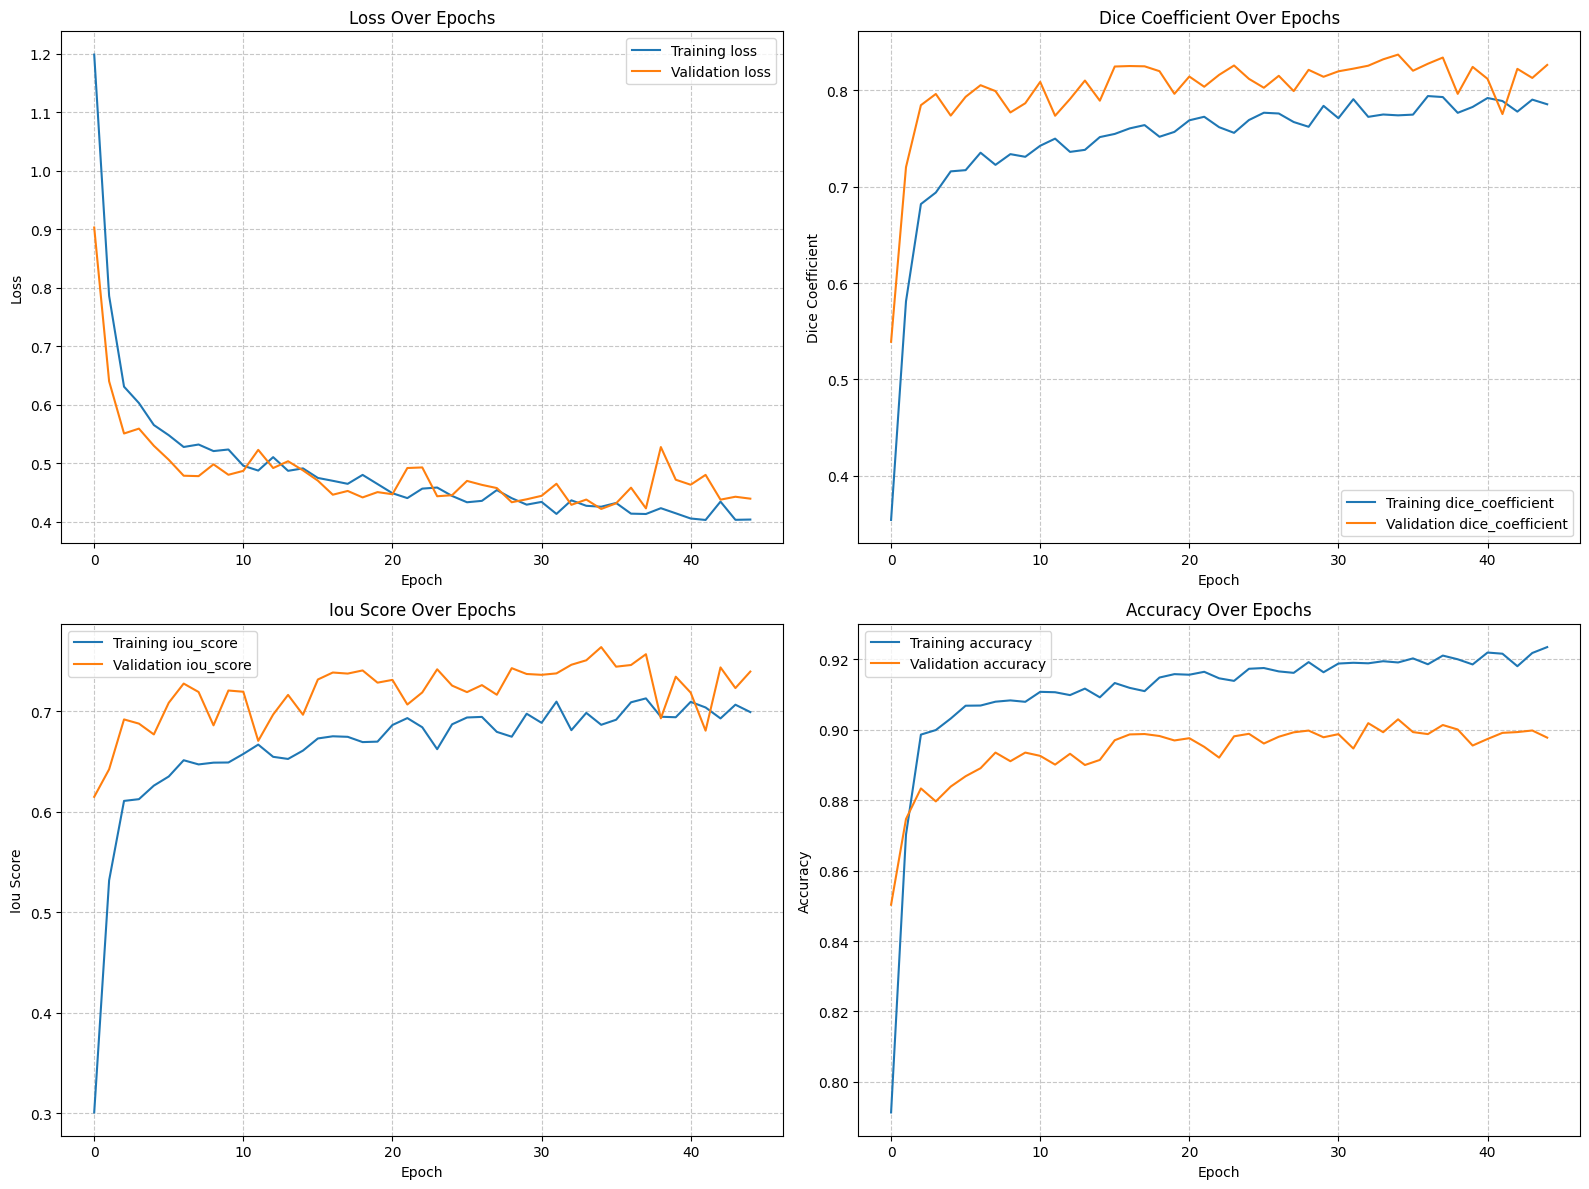

In [55]:
# Cell 15: Define callbacks
# Create checkpoint callback
checkpoint_path = 'water_segmentation_model_best.keras'
checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_iou_score',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Create early stopping callback
early_stopping = callbacks.EarlyStopping(
    monitor='val_iou_score',
    patience=10,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

# Create learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch > 0 and epoch % 10 == 0:
        return lr * 0.8
    return lr

lr_callback = callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

# Create TensorBoard callback
tensorboard_callback = callbacks.TensorBoard(
    log_dir='./logs',
    histogram_freq=1,
    write_graph=True,
    update_freq='epoch'
)

# Cell 16: Train the model
EPOCHS = 50

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stopping,
        lr_callback,
        tensorboard_callback
    ],
    verbose=1
)

# Cell 17: Visualize training history
def plot_training_history(history):
    """Plot training and validation metrics"""
    metrics = ['loss', 'dice_coefficient', 'iou_score', 'accuracy']
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        ax.plot(history.history[metric], label=f'Training {metric}')
        ax.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        ax.set_title(f'{metric.replace("_", " ").title()} Over Epochs')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.replace('_', ' ').title())
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

# Cell 18: Load the best model weights
model.load_weights(checkpoint_path)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.9189 - dice_coefficient: 0.7154 - iou_score: 0.5949 - loss: 0.4932

Test Results:
  loss: 0.5079
  compile_metrics: 0.7107
Visualizing test predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step


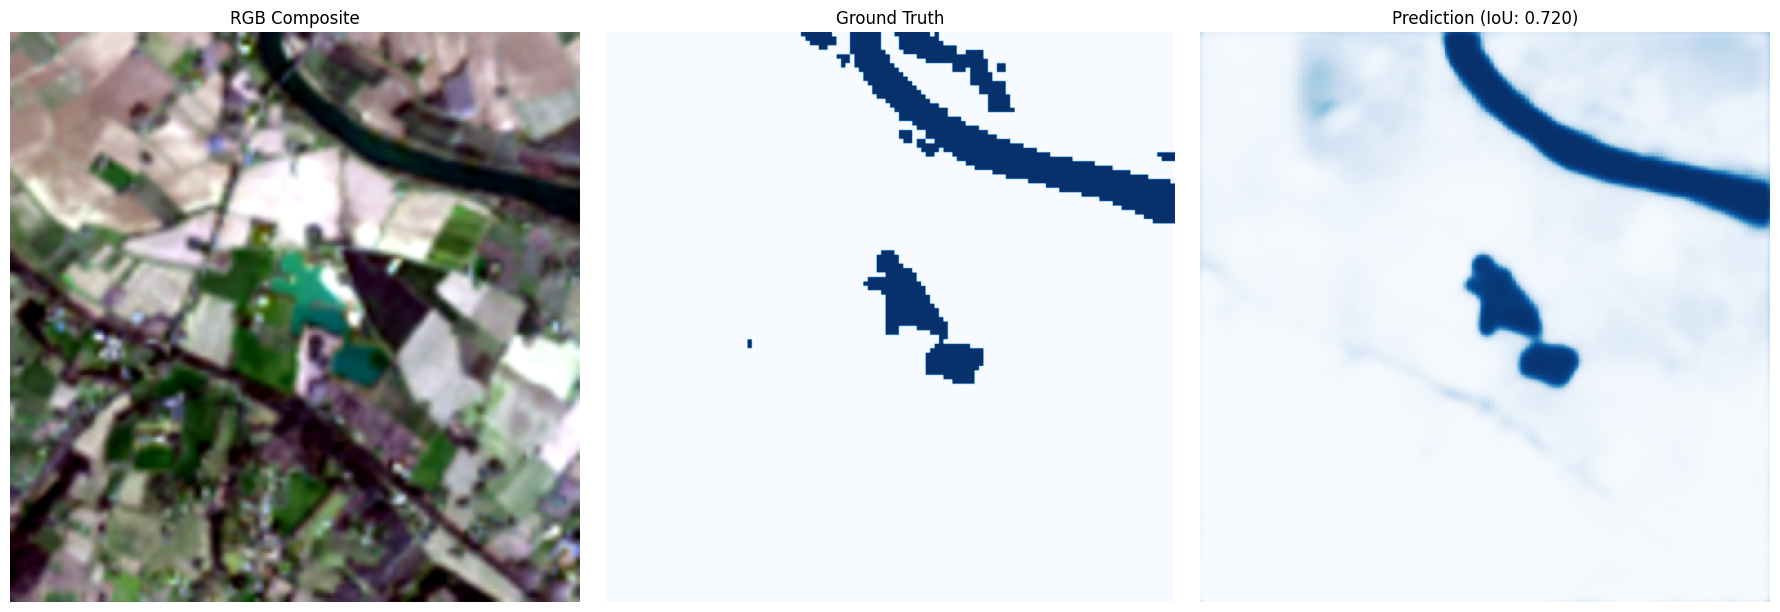

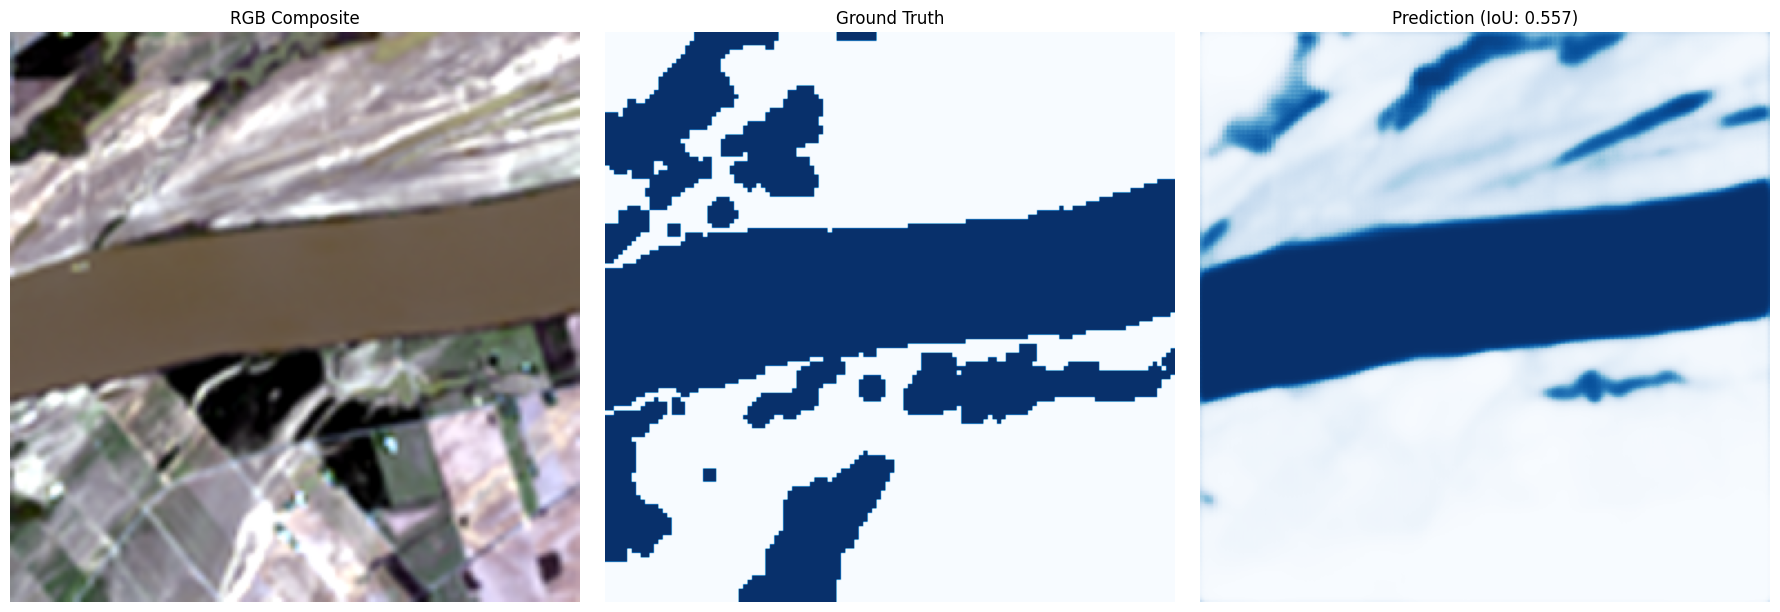

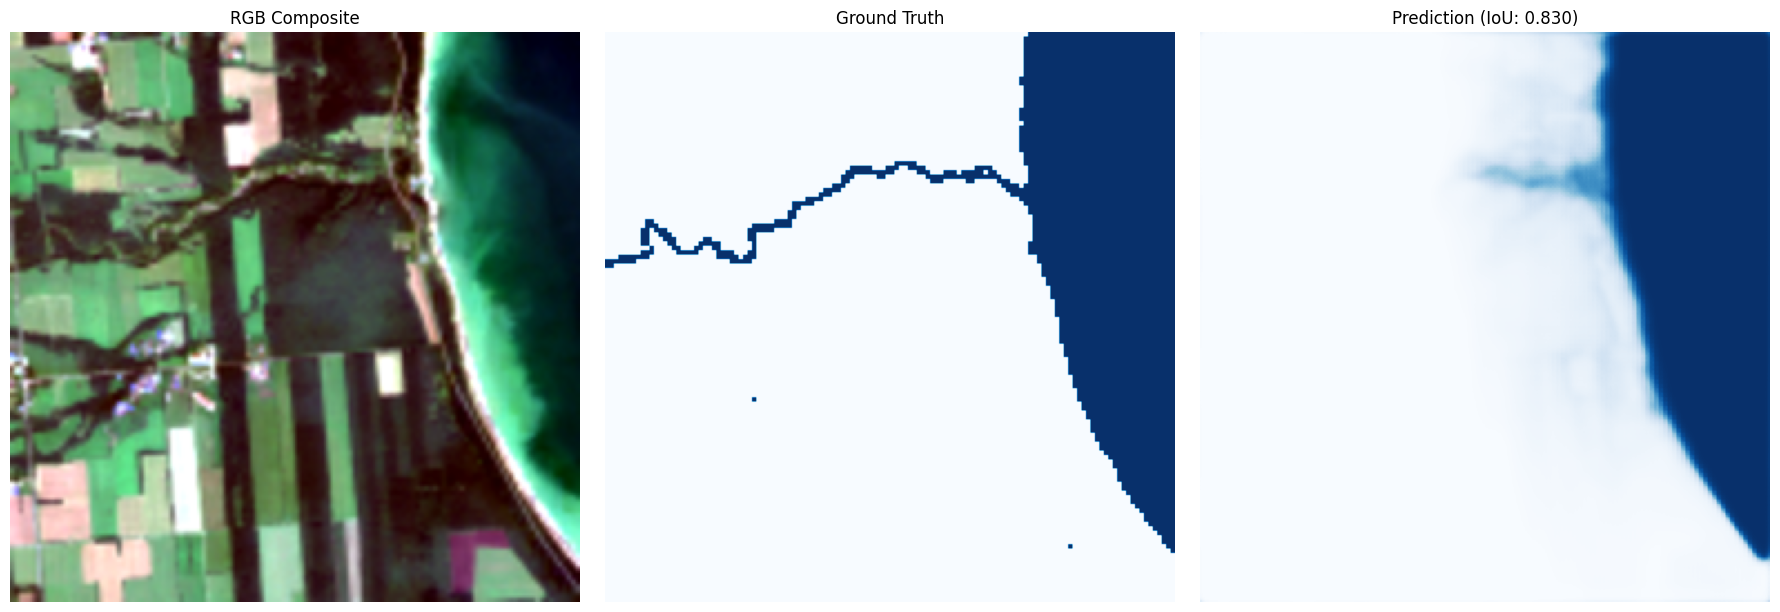

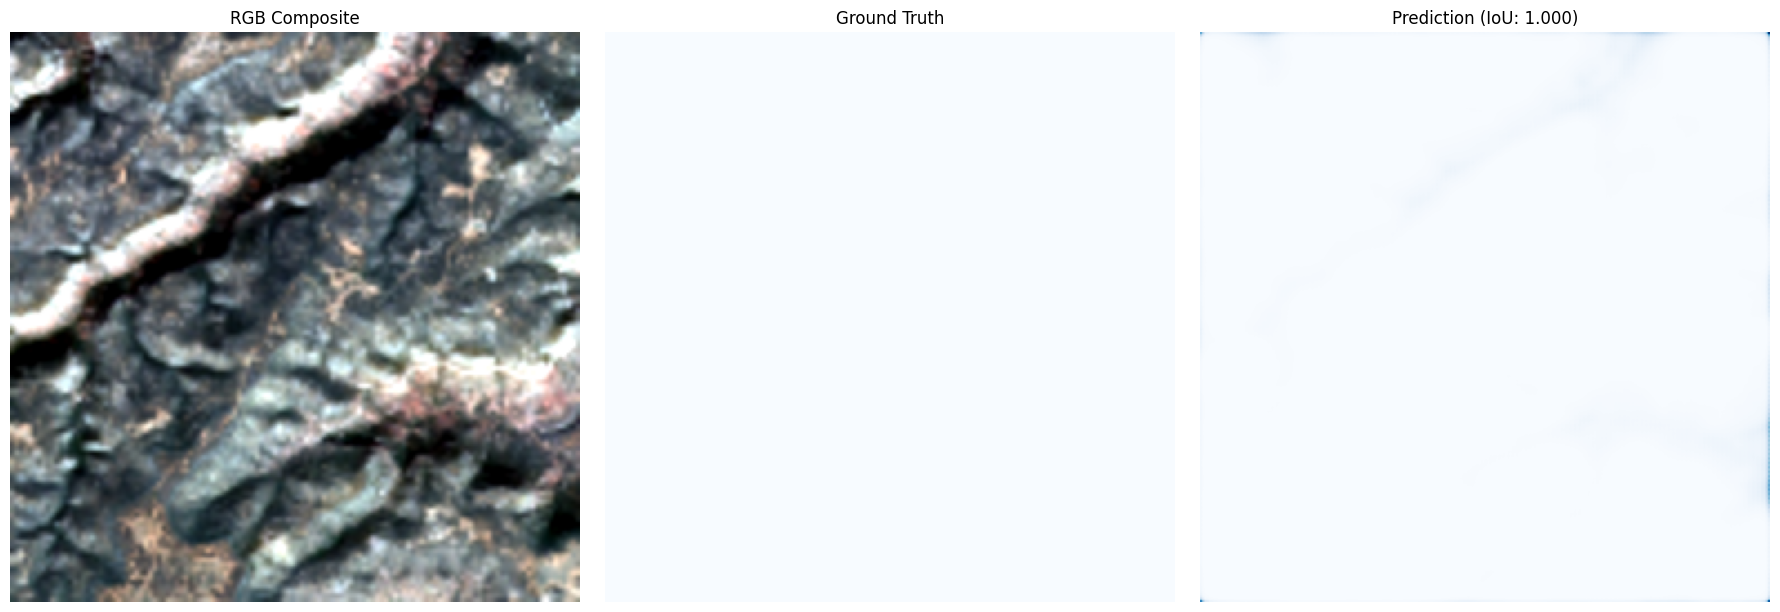

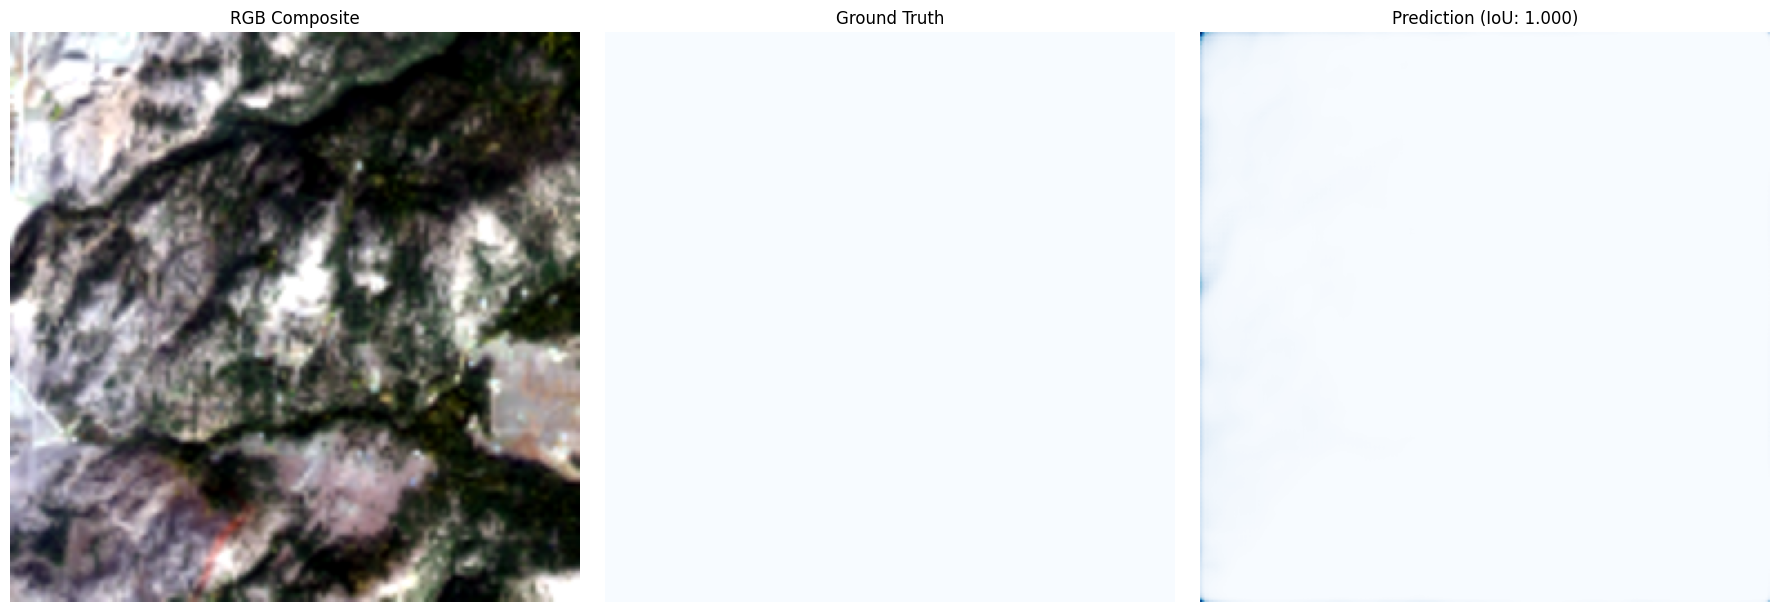

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step

Detailed Test Metrics:
  Precision: 0.8214
  Recall: 0.6704
  F1 Score: 0.7383


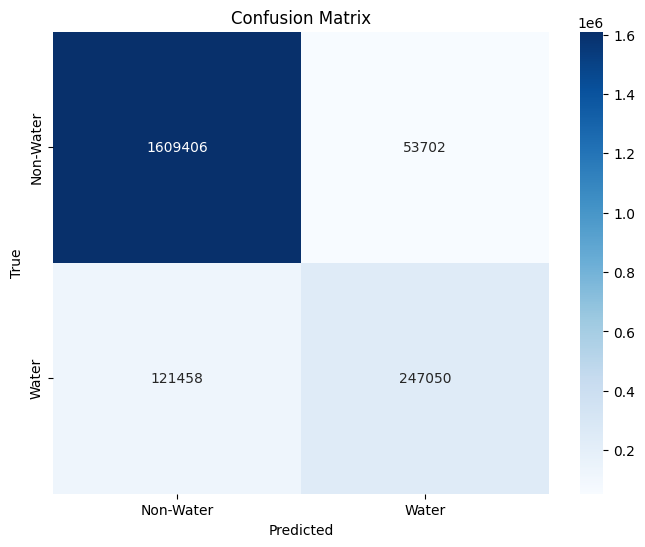

In [56]:
# Cell 19: Evaluate model on test set
test_results = model.evaluate(test_gen, verbose=1)
print("\nTest Results:")
for metric_name, value in zip(model.metrics_names, test_results):
    print(f"  {metric_name}: {value:.4f}")

# Cell 20: Functions for prediction visualization
def visualize_predictions(generator, model, num_samples=5):
    """Visualize model predictions against ground truth"""
    # Get a batch from the generator
    X_batch, y_true_batch = generator[0]
    y_pred_batch = model.predict(X_batch)
    
    for i in range(min(num_samples, len(X_batch))):
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Create RGB visualization (adjust bands based on your data)
        rgb_composite = np.stack([
            X_batch[i,:,:,3],  # Red band
            X_batch[i,:,:,2],  # Green band
            X_batch[i,:,:,1]   # Blue band
        ], axis=-1)
        
        # Normalize for display
        rgb_min = np.percentile(rgb_composite, 2)
        rgb_max = np.percentile(rgb_composite, 98)
        rgb_display = np.clip((rgb_composite - rgb_min) / (rgb_max - rgb_min), 0, 1)
        
        # Plot original image
        axes[0].imshow(rgb_display)
        axes[0].set_title("RGB Composite")
        axes[0].axis('off')
        
        # Plot ground truth
        axes[1].imshow(y_true_batch[i,:,:,0], cmap='Blues')
        axes[1].set_title("Ground Truth")
        axes[1].axis('off')
        
        # Plot prediction
        axes[2].imshow(y_pred_batch[i,:,:,0], cmap='Blues')
        axes[2].set_title(f"Prediction (IoU: {calculate_iou(y_true_batch[i], y_pred_batch[i]):.3f})")
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()

def calculate_iou(y_true, y_pred, threshold=0.5):
    """Calculate IoU for a single image"""
    y_true = y_true[:,:,0].flatten()
    y_pred = (y_pred[:,:,0] > threshold).flatten().astype(np.float32)
    
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    
    if union == 0:
        return 1.0  # If both true and pred are empty, return 1
    
    return intersection / union

# Cell 21: Visualize test predictions
print("Visualizing test predictions:")
visualize_predictions(test_gen, model)

# Cell 22: Calculate detailed metrics on test set
def calculate_detailed_metrics(generator, model, threshold=0.5):
    """Calculate detailed metrics on a generator"""
    all_y_true = []
    all_y_pred = []
    
    # Collect all predictions
    for i in range(len(generator)):
        X_batch, y_batch = generator[i]
        y_pred_batch = model.predict(X_batch)
        
        # Flatten and threshold predictions
        y_true = y_batch.reshape(-1)
        y_pred = (y_pred_batch.reshape(-1) > threshold).astype(np.float32)
        
        all_y_true.extend(y_true)
        all_y_pred.extend(y_pred)
    
    # Convert to numpy arrays
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    
    # Calculate metrics
    precision = precision_score(all_y_true, all_y_pred)
    recall = recall_score(all_y_true, all_y_pred)
    f1 = f1_score(all_y_true, all_y_pred)
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_y_true, all_y_pred)
    
    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }

# Calculate and display detailed metrics
test_metrics = calculate_detailed_metrics(test_gen, model)

print("\nDetailed Test Metrics:")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall: {test_metrics['recall']:.4f}")
print(f"  F1 Score: {test_metrics['f1_score']:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    test_metrics['confusion_matrix'],
    annot=True, 
    fmt='d',
    cmap='Blues',
    xticklabels=['Non-Water', 'Water'],
    yticklabels=['Non-Water', 'Water']
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()